# SÉRIES TEMPORAIS - Queimadas na floresta Amazônica no Brasil e na Paraíba

## Alunos: João Henrique de Araújo Pereira, Samila Ellen Garrido Rodrigues

## Importação das bibliotecas

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

## Carregamento da base de dados

Importando o dataframe das queimadas de todas as Unidades Federativas do Brasil e executando a limpeza dos dados.

Fonte: https://www.kaggle.com/datasets/gustavomodelli/forest-fires-in-brazil

In [2]:
dataset = pd.read_csv('amazon.csv', encoding= "ISO-8859-1")

In [3]:
dataset.number.astype('int64')

0         0
1         0
2         0
3         0
4         0
       ... 
6449    128
6450     85
6451    223
6452    373
6453    119
Name: number, Length: 6454, dtype: int64

In [4]:
df_brazil = dataset.groupby(['year', 'month', 'date']).sum().reset_index()

In [5]:
df_brazil

,year,month,date,state,number
0,1998,Abril,1998-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,0.000
1,1998,Agosto,1998-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,3964.616
2,1998,Dezembro,1998-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,2043.407
3,1998,Fevereiro,1998-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,0.000
4,1998,Janeiro,1998-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,0.000
...,...,...,...,...,...
234,2017,Maio,2017-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,2506.000
235,2017,Março,2017-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,2017.000
236,2017,Novembro,2017-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,6217.379
237,2017,Outubro,2017-01-01,AcreAlagoasAmapaAmazonasBahiaCearaDistrito Fed...,3600.159


Separando os dados da Paraíba para análise.

In [6]:
df = df_brazil
df = dataset[dataset.state == 'Paraiba']

In [7]:
df

,year,state,month,number,date
3347,1998,Paraiba,Janeiro,0.0,1998-01-01
3348,1999,Paraiba,Janeiro,26.0,1999-01-01
3349,2000,Paraiba,Janeiro,0.0,2000-01-01
3350,2001,Paraiba,Janeiro,11.0,2001-01-01
3351,2002,Paraiba,Janeiro,5.0,2002-01-01
...,...,...,...,...,...
3820,2012,Paraiba,Dezembro,54.0,2012-01-01
3821,2013,Paraiba,Dezembro,155.0,2013-01-01
3822,2014,Paraiba,Dezembro,78.0,2014-01-01
3823,2015,Paraiba,Dezembro,30.0,2015-01-01


In [8]:
df[(df.month == 'Janeiro') & (df.year == 2016)]

,year,state,month,number,date
3365,2016,Paraiba,Janeiro,18.0,2016-01-01
3604,2016,Paraiba,Janeiro,113.0,2016-01-01


In [9]:
meses_dicionario = {'Janeiro': '01', 'Fevereiro': '02', 'Março': '03', 'Abril': '04', 'Maio': '05', 'Junho': '06', 'Julho': '07', 'Agosto': '08', 'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'}

In [10]:
# transformando date em datetime sem hora
df['date'] = pd.to_datetime(df['date'], format='ISO8601')

In [11]:
df

,year,state,month,number,date
3347,1998,Paraiba,Janeiro,0.0,1998-01-01
3348,1999,Paraiba,Janeiro,26.0,1999-01-01
3349,2000,Paraiba,Janeiro,0.0,2000-01-01
3350,2001,Paraiba,Janeiro,11.0,2001-01-01
3351,2002,Paraiba,Janeiro,5.0,2002-01-01
...,...,...,...,...,...
3820,2012,Paraiba,Dezembro,54.0,2012-01-01
3821,2013,Paraiba,Dezembro,155.0,2013-01-01
3822,2014,Paraiba,Dezembro,78.0,2014-01-01
3823,2015,Paraiba,Dezembro,30.0,2015-01-01


In [12]:
# fazendo o campo date concordar com o campo month
for i in range(len(df)):
    df.date.iloc[i] = df.date.iloc[i].replace(month=int(meses_dicionario[df.month.iloc[i]]))

In [13]:
df[(df.month == 'Janeiro') & (df.year == 1998)]

,year,state,month,number,date
3347,1998,Paraiba,Janeiro,0.0,1998-01-01
3586,1998,Paraiba,Janeiro,0.0,1998-01-01


In [14]:
# somando os valores de queimadas por mês de cada ano

df = df.groupby(['year', 'month', 'date', 'state']).sum().reset_index()

df.sort_values(by='date', inplace=True)

df

,year,month,date,state,number
4,1998,Janeiro,1998-01-01,Paraiba,0.000
3,1998,Fevereiro,1998-02-01,Paraiba,0.000
8,1998,Março,1998-03-01,Paraiba,0.000
0,1998,Abril,1998-04-01,Paraiba,0.000
7,1998,Maio,1998-05-01,Paraiba,0.000
...,...,...,...,...,...
232,2017,Julho,2017-07-01,Paraiba,893.000
229,2017,Agosto,2017-08-01,Paraiba,990.000
238,2017,Setembro,2017-09-01,Paraiba,31.706
237,2017,Outubro,2017-10-01,Paraiba,257.000


In [15]:
df.set_index('date', inplace=True)

In [16]:
df.drop(['year', 'month', 'state'], axis= 1, inplace= True)

In [17]:
df

,number
date,
1998-01-01,0.000
1998-02-01,0.000
1998-03-01,0.000
1998-04-01,0.000
1998-05-01,0.000
...,...
2017-07-01,893.000
2017-08-01,990.000
2017-09-01,31.706


Após a realização da limpeza dos dados, foi criado um novo dataframe com os dados da Paraíba contendo o índice, baseado na data do registro, e a quantidade de queimadas.

Criando a varíavel `time_series` para armazenar os dados da Paraíba.

In [18]:
time_series = df['number']

Separando os dados de 2014 para frente para testes posteriores.

In [19]:
time_series_test = time_series[time_series.index.year > 2014]
time_series = time_series[time_series.index.year <= 2014]

## Exploração da série temporal

In [20]:
fig = px.line(df, x=df.index, y='number', title='Série Temporal de queimadas na Paraíba')	
fig.update_layout(xaxis_title="Data", yaxis_title="Número de queimadas")
fig.show()

In [21]:
time_series_ano = time_series.groupby(time_series.index.year).sum()
fig = px.line(time_series_ano, x=time_series_ano.index, y='number', title='Número de queimadas na Paraíba por ano')
fig.update_layout(xaxis_title="Ano", yaxis_title="Número de queimadas")
fig.show()

In [22]:
time_series_mes = time_series.groupby([lambda x: x.month]).sum()
fig = px.line(time_series_mes, x=time_series_mes.index, y='number', title='Número de queimadas na Paraíba por mês')
fig.update_layout(xaxis_title="Mês", yaxis_title="Número total de queimadas")
fig.show()

In [23]:
media_movel = time_series.rolling(window = 6)
media_movel = media_movel.mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=media_movel.index, y=media_movel.values,
                    mode='lines',
                    name='lines'))
fig.update_layout(title='Média móvel de 6 meses das queimadas na Paraíba',
                    xaxis_title='Anos',
                    yaxis_title='Número de queimadas')
fig.show()



fig = go.Figure()
fig.add_trace(go.Scatter(x=time_series.index, y=time_series.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=media_movel.index, y=media_movel.values,
                    mode='lines',
                    name='Média móvel'))
fig.update_layout(title='Série histórica das queimadas na Paraíba',
                    xaxis_title='Anos',
                    yaxis_title='Número de queimadas')
fig.show()



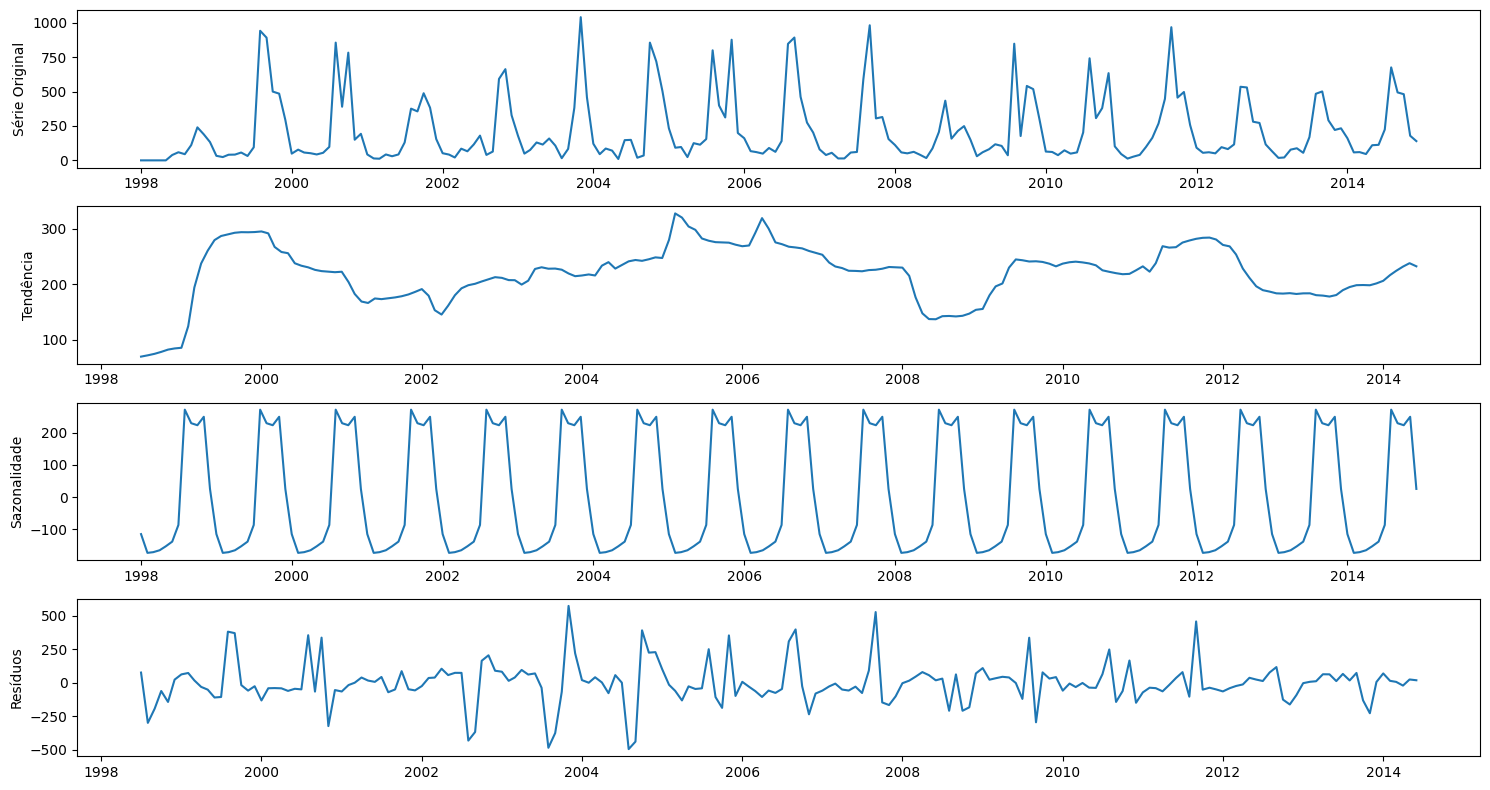

In [24]:
decomposicao = seasonal_decompose(time_series, period=12)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
observed = decomposicao.observed
trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

ax1.plot(observed)
ax1.set_ylabel('Série Original')

ax2.plot(trend)
ax2.set_ylabel('Tendência')

ax3.plot(seasonal)
ax3.set_ylabel('Sazonalidade')

ax4.plot(residual)
ax4.set_ylabel('Resíduos')

plt.tight_layout()

## Testes de estacionariedade

In [25]:
result = adfuller(time_series)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.10f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -3.8309
Valor-p: 0.0026061263
Valores Críticos:
	1%: -3.4652
	5%: -2.8769
	10%: -2.5749


In [26]:
result = kpss(time_series)
print('KPSS')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.10f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[3].items():
    print('\t{}: {:.4f}'.format(key, value))
    

KPSS
Teste Estatístico: 0.0813
Valor-p: 0.1000000000
Valores Críticos:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


C:\Users\JoãoPereira\AppData\Local\Temp\ipykernel_24268\2070646920.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Ambos os testes de estacionariedade confirmaram que a série temporal é estacionária.

## Teste de Heterocedasticidade

Não há evidências de heterocedasticidade (variabilidade na média é constante).


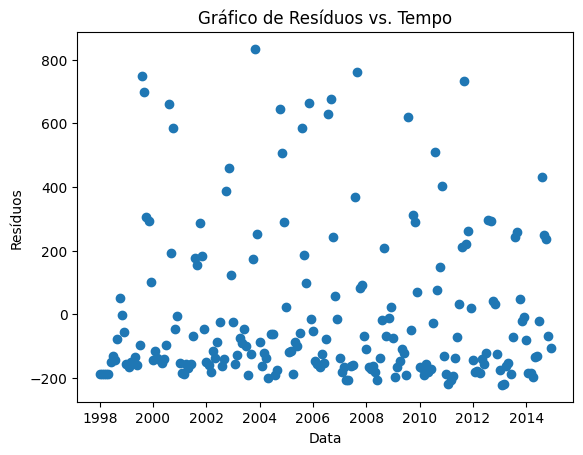

In [27]:

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan


dados = time_series.copy()
dados.index = pd.to_datetime(dados.index)


X = sm.add_constant(np.arange(len(dados))) 
y = dados.values
modelo = sm.OLS(y, X).fit()


residuos = modelo.resid

variancias_residuos = residuos ** 2

# Realize o teste de Breusch-Pagan
teste_het = het_breuschpagan(variancias_residuos, X)


valor_p = teste_het[1]

if valor_p < 0.05:
    print("Há evidências de heterocedasticidade (variabilidade na média não é constante).")
else:
    print("Não há evidências de heterocedasticidade (variabilidade na média é constante).")


plt.scatter(dados.index, residuos)
plt.xlabel("Data")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos vs. Tempo")
plt.show()

## Teste de significância da Sazonalidade

In [28]:
decomposicao = sm.tsa.seasonal_decompose(time_series.values, model='additive', period=12)


var_explicada_sazonal = decomposicao.seasonal.var()


var_total = decomposicao.resid[~np.isnan(decomposicao.resid)].var() + var_explicada_sazonal

prop_var_sazonal = var_explicada_sazonal / var_total

nivel_significancia = 0.05


if prop_var_sazonal > nivel_significancia:
    print('Resultado: A sazonalidade é significativa ao nível de significância de', nivel_significancia)
else:
    print('Resultado: A sazonalidade não é significativa ao nível de significância de', nivel_significancia)

Resultado: A sazonalidade é significativa ao nível de significância de 0.05


## Autocorrelação dos dados

In [29]:
len(time_series)/ 13

15.692307692307692

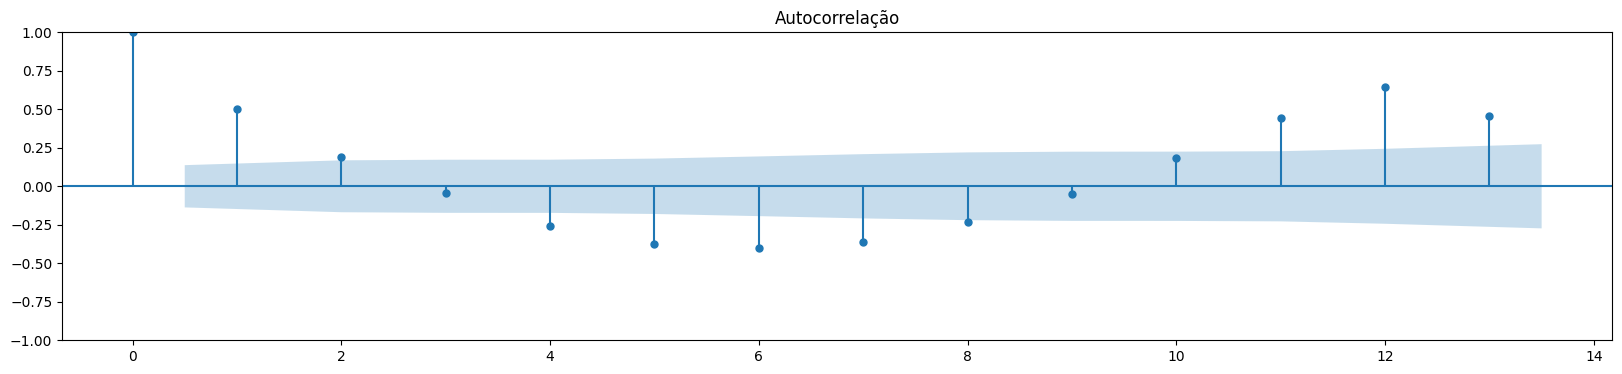

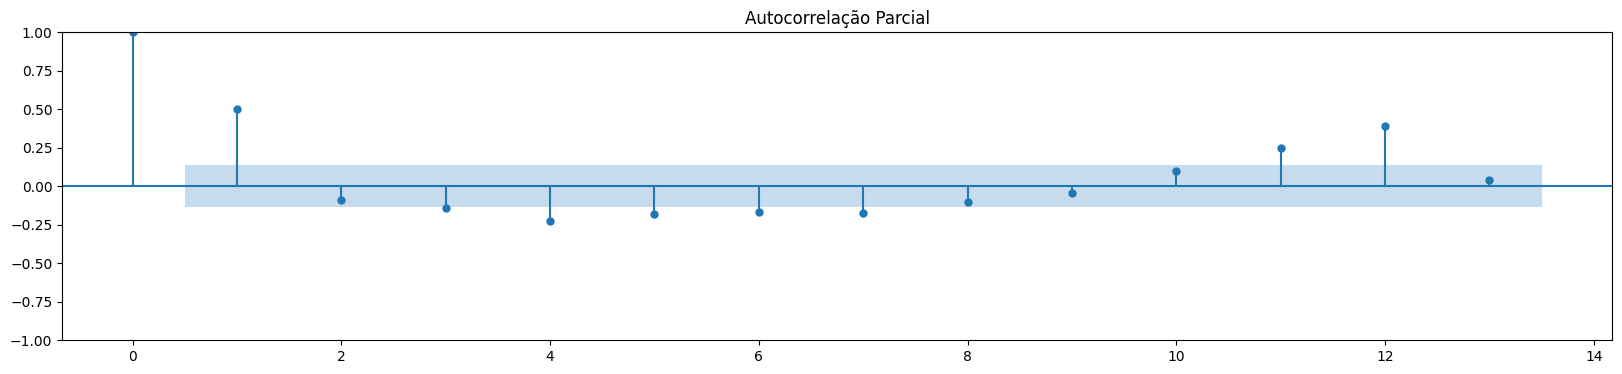

In [30]:

fig1 = plot_acf(time_series, lags=13, title='Autocorrelação')
fig2 = plot_pacf(time_series, lags=13, title='Autocorrelação Parcial')
fig1.figure.set_size_inches(20, 4)
fig2.figure.set_size_inches(20, 4)
plt.show()

## Predição com Suavização exponencial

In [31]:
model_suav_exp = sm.tsa.ExponentialSmoothing(time_series, seasonal='add', seasonal_periods=12, initialization_method= 'heuristic').fit()

prev = model_suav_exp.predict(start=time_series_test.index[0], end=time_series_test.index[-1])
fig = go.Figure()


fig.add_trace(go.Scatter(x=time_series_test.index, y=time_series_test.values,
                    mode='lines',
                    name='Observado'))

fig.add_trace(go.Scatter(x=prev.index, y=prev.values,
                    mode='lines',
                    name='Previsto'))

fig.update_layout(title='Previsão de queimadas na Paraíba',
                    xaxis_title='Anos',
                    yaxis_title='Número de queimadas')

fig.show()

c:\Users\JoãoPereira\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [32]:
print(model_suav_exp.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   number   No. Observations:                  204
Model:             ExponentialSmoothing   SSE                        6245609.898
Optimized:                         True   AIC                           2135.171
Trend:                             None   BIC                           2181.625
Seasonal:                      Additive   AICC                          2138.080
Seasonal Periods:                    12   Date:                 Mon, 25 Sep 2023
Box-Cox:                          False   Time:                         07:54:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757143                alpha                 True
smoothing_seasonal       

## Análise dos resíduos da Suavização exponencial

In [33]:
resid_exp = model_suav_exp.resid

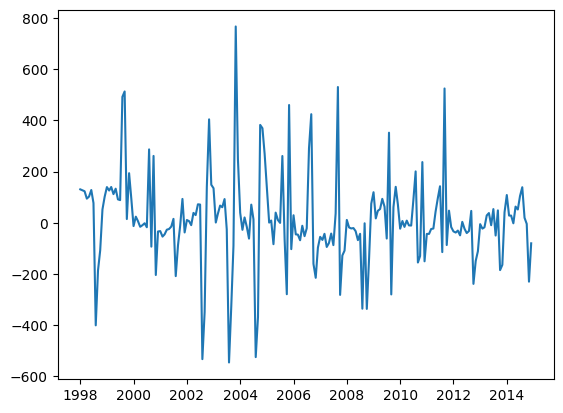

In [34]:
resid_plot = plt.plot(resid_exp)
plt.show()

### Normalidade dos resíduos

<Axes: ylabel='Density'>

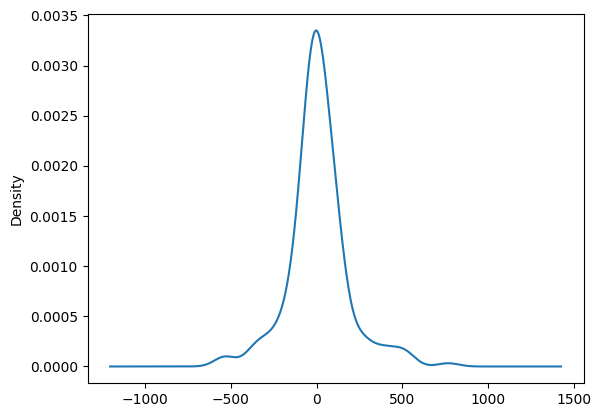

In [35]:
resid_exp.plot(kind='kde')

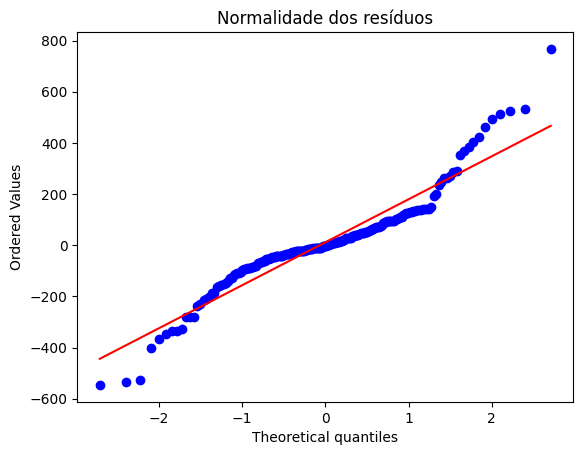

In [36]:
stats.probplot(resid_exp, dist="norm", plot=plt)
plt.title("Normalidade dos resíduos")
plt.show()

In [37]:
if stats.shapiro(resid_exp)[1] < 0.05:
    print("Os resíduos NÃO seguem uma distribuição normal.")
else:
    print("Os resíduos seguem uma distribuição normal.")

Os resíduos NÃO seguem uma distribuição normal.


### Autocorrelação dos resíduos

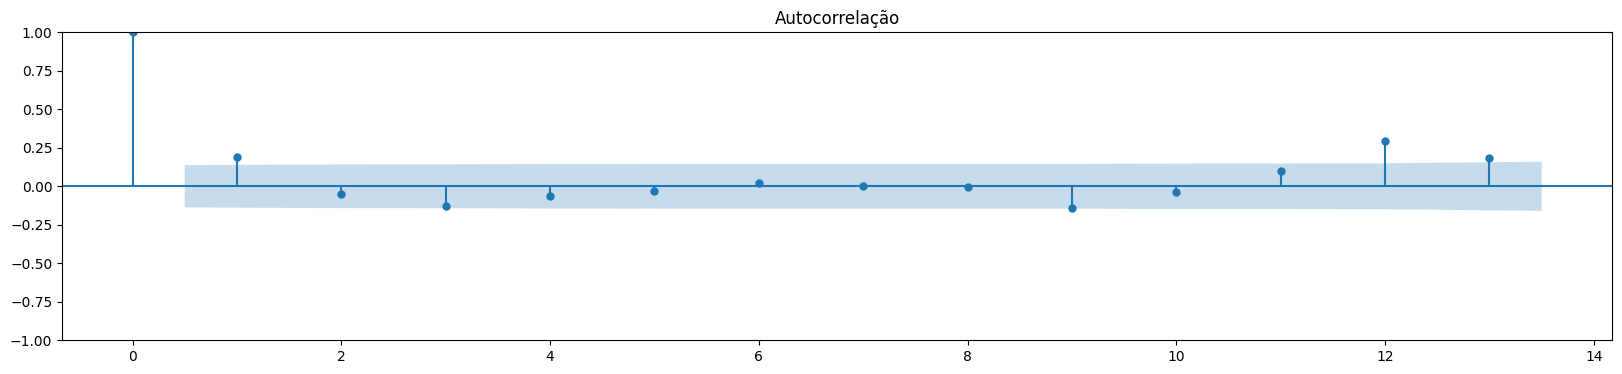

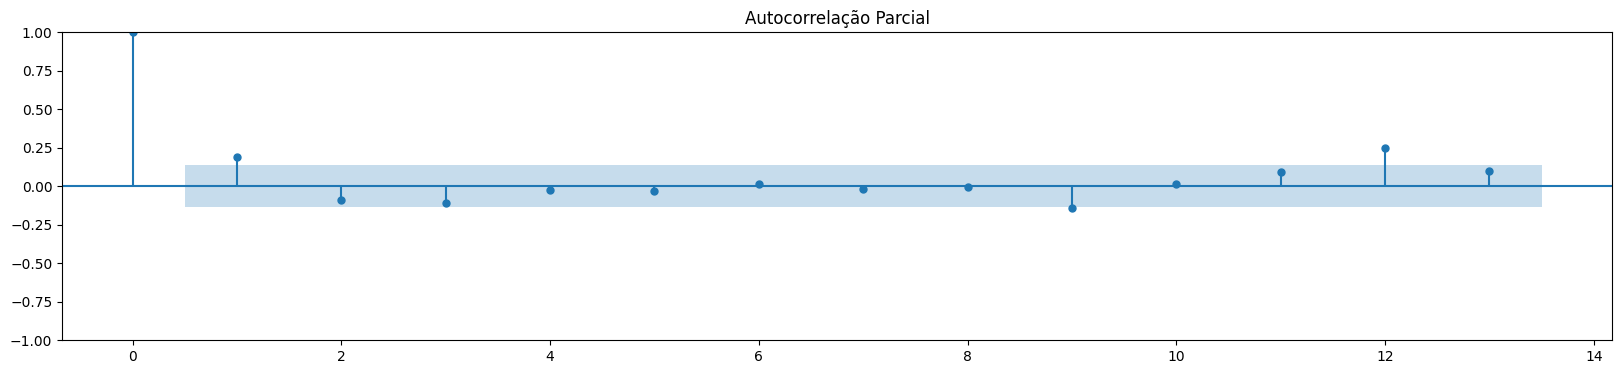

In [38]:
fig1 = plot_acf(resid_exp, lags=13, title='Autocorrelação')
fig2 = plot_pacf(resid_exp, lags=13, title='Autocorrelação Parcial')
fig1.figure.set_size_inches(20, 4)
fig2.figure.set_size_inches(20, 4)
plt.show()

## Diferenciação Sazonal

Text(0, 0.5, 'Resíduos')

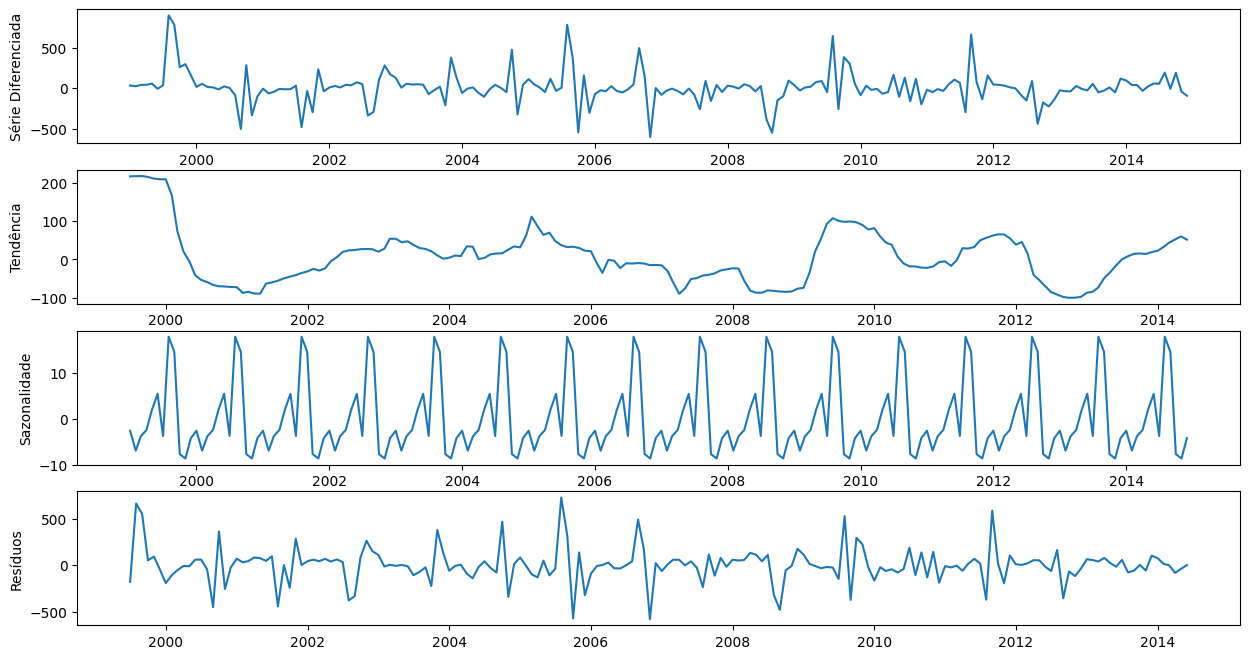

In [39]:
time_series_diff = time_series.diff(12).dropna()
decomposicao = seasonal_decompose(time_series_diff, period=12)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
observed = decomposicao.observed
trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

ax1.plot(observed)
ax1.set_ylabel('Série Diferenciada')

ax2.plot(trend)
ax2.set_ylabel('Tendência')

ax3.plot(seasonal)
ax3.set_ylabel('Sazonalidade')

ax4.plot(residual)
ax4.set_ylabel('Resíduos')


In [40]:
var_explicada_sazonal = decomposicao.seasonal.var()

# Examine a variância total
var_total = decomposicao.resid[~np.isnan(decomposicao.resid)].var() + var_explicada_sazonal

# Calcule a proporção de variância explicada pela sazonalidade
prop_var_sazonal = var_explicada_sazonal / var_total

# Defina um nível de significância
nivel_significancia = 0.05

# Realize um teste de hipótese para verificar a significância da sazonalidade
if prop_var_sazonal > nivel_significancia:
    print('Resultado: A sazonalidade é significativa ao nível de significância de', nivel_significancia)
else:
    print('Resultado: A sazonalidade NÃO é significativa ao nível de significância de', nivel_significancia)

Resultado: A sazonalidade NÃO é significativa ao nível de significância de 0.05


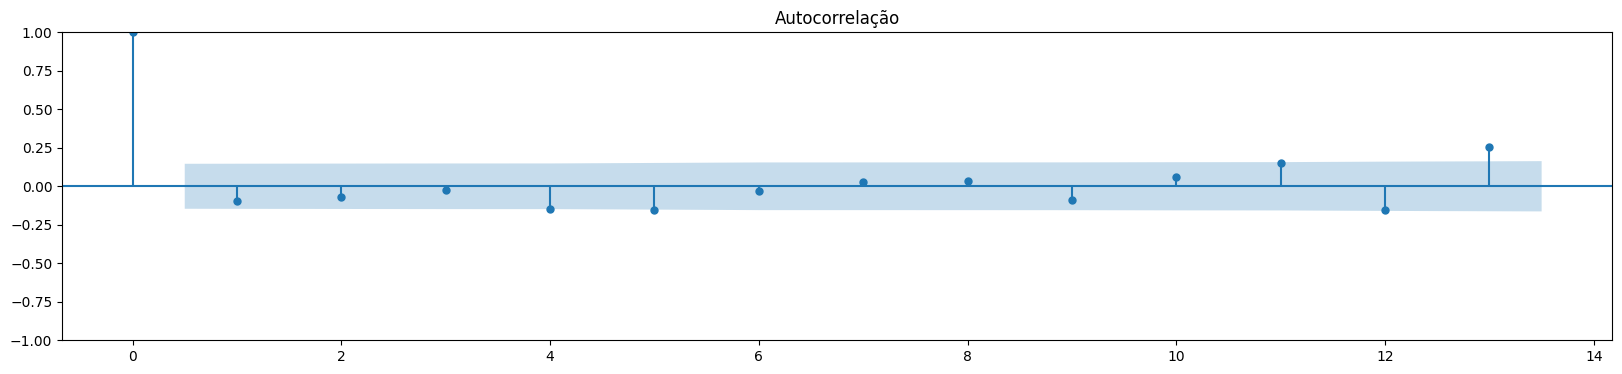

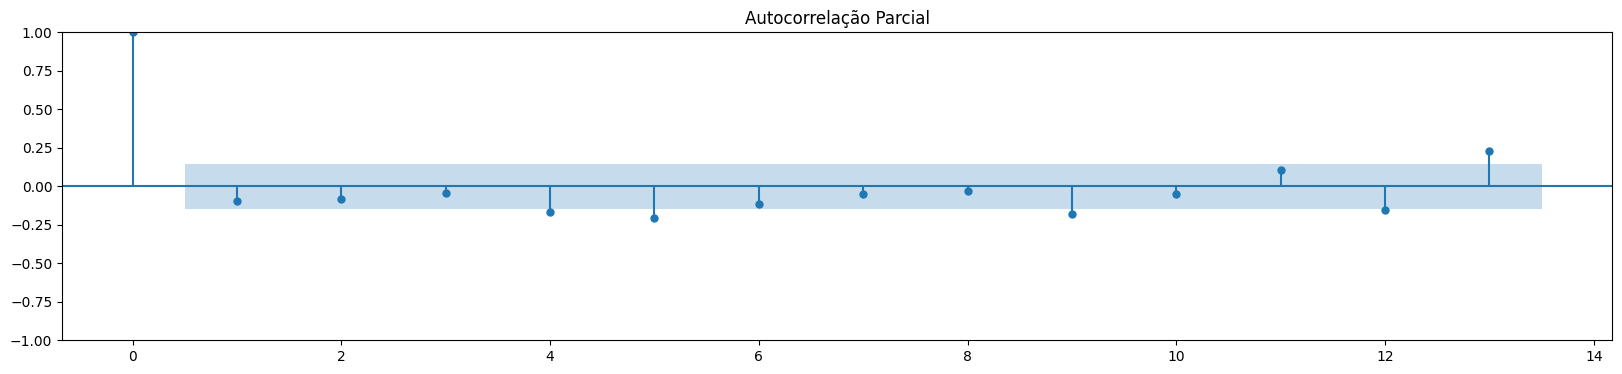

In [41]:
fig1 = plot_acf(decomposicao.resid.dropna(), lags=13, title='Autocorrelação')
fig2 = plot_pacf(decomposicao.resid.dropna(), lags=13, title='Autocorrelação Parcial')
fig1.figure.set_size_inches(20, 4)
fig2.figure.set_size_inches(20, 4)
plt.show()

In [42]:
warnings.filterwarnings('ignore')

## Predição com SARIMA

In [43]:
model_sarima = sm.tsa.SARIMAX(time_series_diff, order=(4,0,4), seasonal_order=(4,1,5,12)).fit()

In [44]:
fig = go.Figure()
prev = model_sarima.predict(start=time_series_test.index[0], end=time_series_test.index[-1])

time_series_diff_test = time_series_test.diff(12).dropna()
fig.add_trace(go.Scatter(x=time_series_diff_test.index, y=time_series_diff_test.values,
                    mode='lines',
                    name='Observado'))

fig.add_trace(go.Scatter(x=prev.index, y=prev.values,
                    mode='lines',
                    name='Previsto'))

fig.update_layout(title='Previsão de queimadas na Paraíba',
                    xaxis_title='Anos',
                    yaxis_title='Número de queimadas')

fig.show()

## Análise dos resíduos do SARIMA

In [45]:
resid_sarima = model_sarima.resid

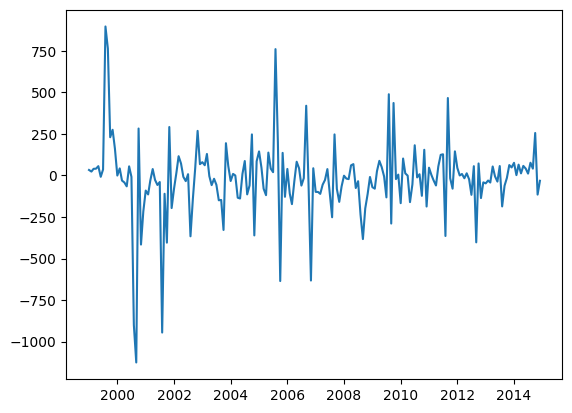

In [46]:
resid_sarima_plot = plt.plot(resid_sarima)
plt.show()

### Normalidade dos resíduos

<Axes: ylabel='Density'>

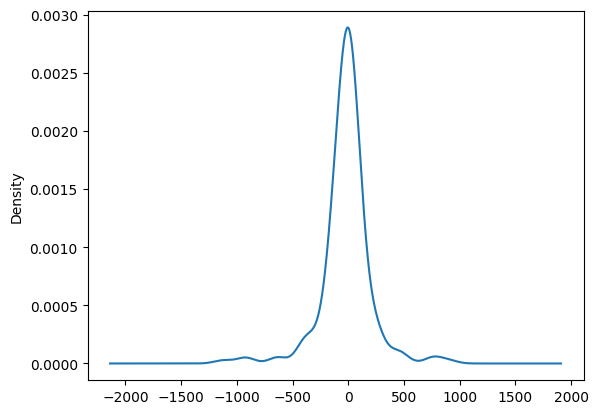

In [47]:
resid_sarima.plot(kind='kde')

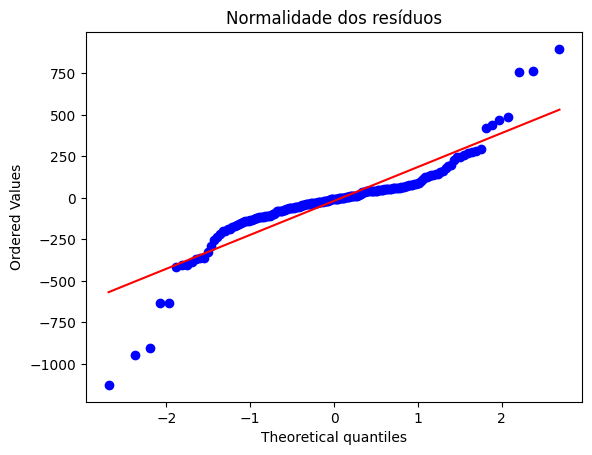

In [48]:
stats.probplot(resid_sarima, dist="norm", plot=plt)
plt.title("Normalidade dos resíduos")
plt.show()

In [49]:
if stats.shapiro(resid_sarima)[1] < 0.05:
    print("Os resíduos NÃO seguem uma distribuição normal.")
else:
    print("Os resíduos seguem uma distribuição normal.")

Os resíduos NÃO seguem uma distribuição normal.


### Autocorrelação dos resíduos

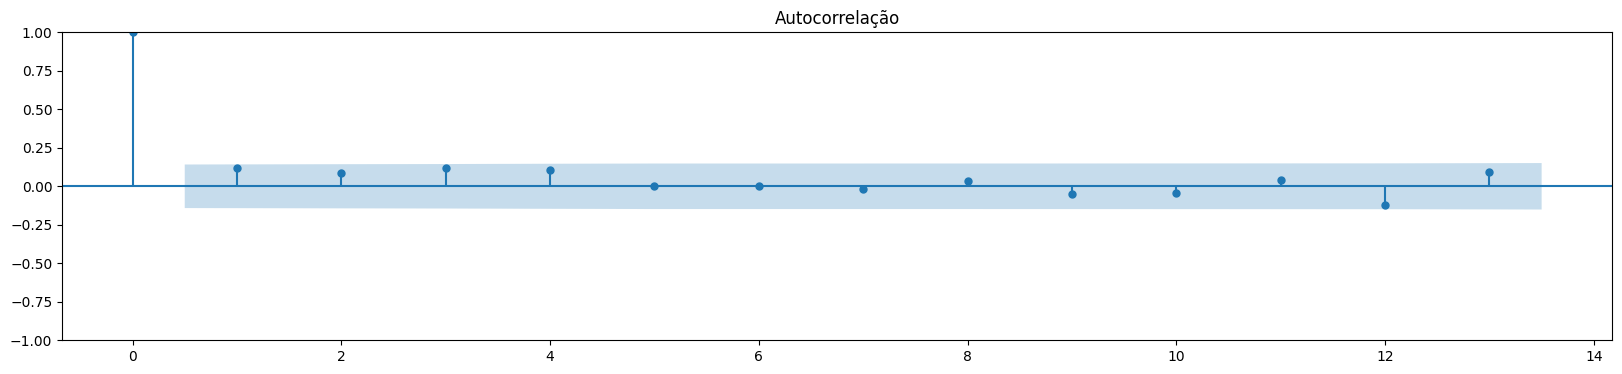

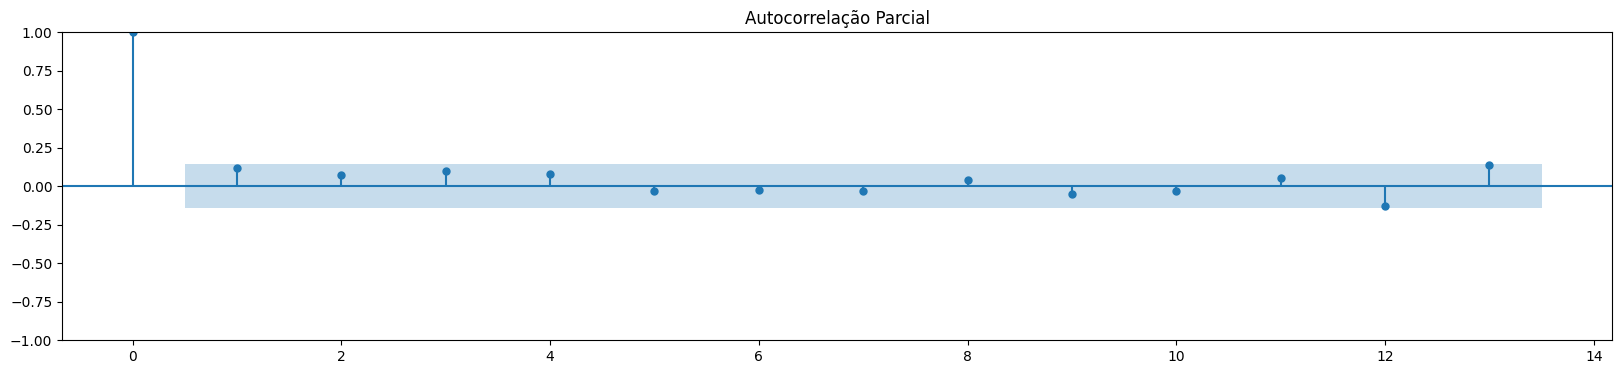

In [50]:
fig1 = plot_acf(resid_sarima, lags=13, title='Autocorrelação')
fig2 = plot_pacf(resid_sarima, lags=13, title='Autocorrelação Parcial')
fig1.figure.set_size_inches(20, 4)
fig2.figure.set_size_inches(20, 4)
plt.show()

## AIC dos modelos

In [51]:
aic_exp = model_suav_exp.aic
aic_sarima = model_sarima.aic

print('AIC Exponential Smoothing:', aic_exp)
print('AIC SARIMA:', aic_sarima)

AIC Exponential Smoothing: 2135.17095041938
AIC SARIMA: 2486.593288140675
